In [1]:
#ANN model that can be generalized for both classification and regresssion tasks
#the data contains the pickup date,time,latitude & longitude of pickup 
#and dropoff locations and number of passengers
#Steps to form model for the dataset
 #->Read the data
 #->Feature Engineering  ->Calculate Distance
                        #->Derive useful Date and Time statistics
                        #->Deal with categorical data using embedding
                        #->Use a TabularModel class to work with continous and cartegorical data


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('NYCTaxiFares.csv')

In [4]:
df.tail()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
119995,2010-04-18 14:33:03 UTC,15.3,1,-73.955857,40.784590,-73.981941,40.736789,1
119996,2010-04-23 10:27:48 UTC,15.3,1,-73.996329,40.772727,-74.049890,40.740413,1
119997,2010-04-18 18:50:40 UTC,12.5,1,-73.988574,40.749772,-74.011541,40.707799,3
119998,2010-04-13 08:14:44 UTC,4.9,0,-74.004449,40.724529,-73.992697,40.730765,1
119999,2010-04-17 16:00:14 UTC,5.3,0,-73.955415,40.771920,-73.967623,40.763015,3


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 7.3+ MB


In [6]:
df.describe()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,10.040326,0.333333,-73.976626,40.751443,-73.974501,40.751695,1.347167
std,7.500134,0.471406,0.031497,0.025821,0.032419,0.030279,0.759263
min,2.500000,0.000000,-74.465447,40.121653,-74.443323,40.164927,1.000000
25%,5.700000,0.000000,-73.992386,40.736594,-73.991478,40.735914,1.000000
50%,7.700000,0.000000,-73.982084,40.753661,-73.980411,40.754441,1.000000
75%,11.300000,1.000000,-73.968710,40.768020,-73.965500,40.768880,1.000000
max,49.900000,1.000000,-73.311845,40.981292,-73.496140,40.993498,5.000000


In [7]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [8]:
#no missing data
#no need for any kind of imputer,now we can clean the data and make it more meaningful
#as we need to predict fare_amount with help of other attributes ,it is a regression problem
#currently we can ignore fare_class as it gives more than enough info about fare_amount

In [9]:
#as we are just using new york taxis as dataset the coordinates will not differ much 
#so rather than using the coordinates direcly as our features 
#we can use them to find the distance of the ride using Haversine formula

In [10]:
def haversine_distance(df, lat1, long1, lat2, long2):
    '''
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    '''
    r = 6371 # average radius of Earth in kilometers
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda= np.radians(df[long2]-df[long1])
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers
    return d

In [11]:
df['dist_km'] = haversine_distance(df,'pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude')

In [12]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [13]:
#now we should engineer our datatime column
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
 8   dist_km            120000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


In [15]:
my_time = df['pickup_datetime'][0]

In [16]:
#as the data is based on nyc where the time is in EDT which is 4hours behind the UTC time format given
#it is important as it helps to detemine AM,PM etc.
df['EDTdate']=df['pickup_datetime']-pd.Timedelta(hours=4)

In [17]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00


In [18]:
df['Hour'] = df['EDTdate'].dt.hour

In [19]:
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')

In [20]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm


In [21]:
df['Weekday'] = df['EDTdate'].dt.strftime("%a")

In [22]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


In [23]:
df['Weekend'] = np.where((df['Weekday'] == 'Sat') | (df['Weekday'] == 'Sun'), 'Y', 'N')

In [24]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday,Weekend
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon,N
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat,Y
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat,Y
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun,Y
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri,N


In [25]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday',
       'Weekend'],
      dtype='object')

In [26]:
#we need to evaluate both categorical as well as continous features
#first we will deal with the categorical columns
cat_cols = ['Hour','AMorPM','Weekday','Weekend']#categorical columns
cont_cols = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude',
       'passenger_count','dist_km']#continous columns
y_col = ['fare_class']#target column

In [27]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                               int64
AMorPM                            object
Weekday                           object
Weekend                           object
dtype: object

In [28]:
#we used the cat_cols to make the categorical columns in category datatype
#so that we can encode it using .cat.codes.values
for cat in cat_cols:
    df[cat]=df[cat].astype('category')

In [29]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                            category
AMorPM                          category
Weekday                         category
Weekend                         category
dtype: object

In [30]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): ['am', 'pm']

In [31]:
df['Weekday'].head()

0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: Weekday, dtype: category
Categories (7, object): ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']

In [32]:
df['Weekend'].head()

0    N
1    Y
2    Y
3    Y
4    N
Name: Weekend, dtype: category
Categories (2, object): ['N', 'Y']

In [33]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [34]:
df['Weekday'].cat.codes.values

array([1, 2, 2, ..., 3, 5, 2], dtype=int8)

In [35]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkday = df['Weekday'].cat.codes.values
wkend = df['Weekend'].cat.codes.values

In [36]:
wkend

array([0, 1, 1, ..., 1, 0, 1], dtype=int8)

In [37]:
#making a 2d array that is derived from the categorical columns
#this is like df.values of our own
cats = np.stack([hr,ampm,wkday,wkend],axis=1)
cats

array([[ 4,  0,  1,  0],
       [11,  0,  2,  1],
       [ 7,  0,  2,  1],
       ...,
       [14,  1,  3,  1],
       [ 4,  0,  5,  0],
       [12,  1,  2,  1]], dtype=int8)

In [38]:
#this is all what happens behind the scenes this all can just be done in 3 line
#cat_cols = ['Hour','AMorPM','Weekday','Weekend']
#for cat in cat_cols:
    #df[cat]=df[cat].astype('category')
#v_cats = np.stack([df[col].cat.codes.values for col in cat_cols],1)

In [39]:
#v_cats

In [40]:
cats = torch.tensor(cats,dtype=torch.int64)

In [41]:
cats =cats.cuda()
cats

tensor([[ 4,  0,  1,  0],
        [11,  0,  2,  1],
        [ 7,  0,  2,  1],
        ...,
        [14,  1,  3,  1],
        [ 4,  0,  5,  0],
        [12,  1,  2,  1]], device='cuda:0')

In [42]:
conts = np.stack([df[col].values for col in cont_cols],axis=1)

In [43]:
conts

array([[-73.992365  ,  40.730521  , -73.975499  ,  40.744746  ,
          1.        ,   2.12631159],
       [-73.990078  ,  40.740558  , -73.974232  ,  40.744114  ,
          1.        ,   1.39230687],
       [-73.994149  ,  40.751118  , -73.960064  ,  40.766235  ,
          2.        ,   3.32676344],
       ...,
       [-73.988574  ,  40.749772  , -74.011541  ,  40.707799  ,
          3.        ,   5.05252282],
       [-74.004449  ,  40.724529  , -73.992697  ,  40.730765  ,
          1.        ,   1.20892296],
       [-73.955415  ,  40.77192   , -73.967623  ,  40.763015  ,
          3.        ,   1.42739869]])

In [44]:
conts = torch.tensor(conts,dtype=torch.float)

In [45]:
conts =conts.cuda()
conts

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   5.0525],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.2089],
        [-73.9554,  40.7719, -73.9676,  40.7630,   3.0000,   1.4274]],
       device='cuda:0')

In [46]:
y = torch.tensor(df[y_col].values).flatten().cuda()
y

tensor([0, 0, 1,  ..., 1, 0, 0], device='cuda:0')

In [47]:
cats.shape

torch.Size([120000, 4])

In [48]:
conts.shape

torch.Size([120000, 6])

In [49]:
y.shape

torch.Size([120000])

In [50]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]

In [51]:
cat_szs

[24, 2, 7, 2]

In [52]:
emb_szs = [(size,min(50,(size+1)//2)) for size in cat_szs]

In [53]:
emb_szs

[(24, 12), (2, 1), (7, 4), (2, 1)]

In [54]:
catz = cats[:2]
catz

tensor([[ 4,  0,  1,  0],
        [11,  0,  2,  1]], device='cuda:0')

In [55]:
selfembeds=nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs]).cuda()

In [56]:
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
  (3): Embedding(2, 1)
)

In [57]:
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))

In [58]:
embeddingz

[tensor([[ 0.3376, -1.3193, -0.8214, -1.2644,  1.7672, -0.2105, -0.1140,  0.0698,
          -0.8081, -0.5417,  0.1840, -0.9045],
         [-0.3250,  0.1594,  1.4040, -0.7850,  1.6728, -0.7149, -1.6042, -0.2312,
          -0.4392,  0.6706,  0.9528,  0.6713]], device='cuda:0',
        grad_fn=<EmbeddingBackward0>),
 tensor([[1.4144],
         [1.4144]], device='cuda:0', grad_fn=<EmbeddingBackward0>),
 tensor([[ 1.2055, -0.3360,  0.9957, -0.0532],
         [-2.2471, -0.3935, -1.5082,  0.4333]], device='cuda:0',
        grad_fn=<EmbeddingBackward0>),
 tensor([[1.6203],
         [0.1980]], device='cuda:0', grad_fn=<EmbeddingBackward0>)]

In [59]:
z = torch.cat(embeddingz,1)

In [60]:
z

tensor([[ 0.3376, -1.3193, -0.8214, -1.2644,  1.7672, -0.2105, -0.1140,  0.0698,
         -0.8081, -0.5417,  0.1840, -0.9045,  1.4144,  1.2055, -0.3360,  0.9957,
         -0.0532,  1.6203],
        [-0.3250,  0.1594,  1.4040, -0.7850,  1.6728, -0.7149, -1.6042, -0.2312,
         -0.4392,  0.6706,  0.9528,  0.6713,  1.4144, -2.2471, -0.3935, -1.5082,
          0.4333,  0.1980]], device='cuda:0', grad_fn=<CatBackward0>)

In [61]:
selfembdrop = nn.Dropout(0.4).cuda

In [62]:
z = selfembdrop(z)

In [63]:
z

Dropout(p=0.4, inplace=False)

In [64]:
class TabularModel(nn.Module):
    
    def __init__(self,emb_szs,n_cont,out_sz,layers,p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])
        # create a list of embeddings for categorical variables where each embedding has size 'nf' 
        # corresponding to the number of unique categories 'ni'
        self.emb_drop = nn.Dropout(p)
        # dropout some of the embeddings to avoid overfitting
        self.bn_cont = nn.BatchNorm1d(n_cont)
        # normalize the continuous variables
        
        layerlist = []
        n_emb = sum([nf for ni,nf in emb_szs])
        # calculate the total number of embedding layers required for categorical data
        n_in = n_emb + n_cont
        # total input layer size: sum of embedded layers and n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) # add a linear layer with input size n_in and output size i
            layerlist.append(nn.ReLU(inplace=True)) # add a ReLU activation function
            layerlist.append(nn.BatchNorm1d(i)) # add batch normalization
            layerlist.append(nn.Dropout(p)) # add dropout regularization
            n_in = i 
        layerlist.append(nn.Linear(layers[-1],out_sz)) 
        # add a final linear layer with input size 'layers[-1]' and output size 'out_sz'
        self.layers = nn.Sequential(*layerlist)
        # wrap all the layers in a sequential container
        
    def forward(self,x_cat,x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i])) # concatenate the embeddings of categorical variables
        x = torch.cat(embeddings,1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x,x_cont],1) # concatenate the categorical embeddings and continuous variables
        x = self.layers(x) # pass the input through the sequential layers
        return x

In [65]:
torch.manual_seed(33)
model = TabularModel(emb_szs,conts.shape[1],2,[200,100],p=0.4)

In [66]:
gpu_model = model.cuda()

In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gpu_model.parameters(),lr=0.01)

In [68]:
batch_size = 60000
test_size = int(batch_size*0.2)
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]

In [69]:
y_train = y[:batch_size-test_size]
y_test  = y[batch_size-test_size:batch_size]

In [70]:
len(y_train)

48000

In [71]:
len(cat_test)

12000

In [72]:

import time
start_time = time.time()
epochs = 500
losses = []
for i in range(epochs):
    i+=1
    y_pred = gpu_model(cat_train,con_train)
    loss = criterion(y_pred,y_train)
    losses.append(loss.cpu().detach().numpy())
    
    if i%10 ==1:
        print(f'epoch:{i} loss is {loss}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
duration = time.time() - start_time
print(f'the training time: {duration/60} minutes')

epoch:1 loss is 0.8005614280700684
epoch:11 loss is 0.5509700775146484
epoch:21 loss is 0.48052075505256653
epoch:31 loss is 0.42560112476348877
epoch:41 loss is 0.39937451481819153
epoch:51 loss is 0.38008707761764526
epoch:61 loss is 0.36145487427711487
epoch:71 loss is 0.35145455598831177
epoch:81 loss is 0.3417620062828064
epoch:91 loss is 0.3373865485191345
epoch:101 loss is 0.33352893590927124
epoch:111 loss is 0.3236349821090698
epoch:121 loss is 0.3152180314064026
epoch:131 loss is 0.3081424832344055
epoch:141 loss is 0.307780385017395
epoch:151 loss is 0.30547723174095154
epoch:161 loss is 0.3056403398513794
epoch:171 loss is 0.30112046003341675
epoch:181 loss is 0.29706206917762756
epoch:191 loss is 0.29572704434394836
epoch:201 loss is 0.2936989963054657
epoch:211 loss is 0.2914867103099823
epoch:221 loss is 0.29111477732658386
epoch:231 loss is 0.2896921932697296
epoch:241 loss is 0.2898314893245697
epoch:251 loss is 0.28789305686950684
epoch:261 loss is 0.28482791781425476

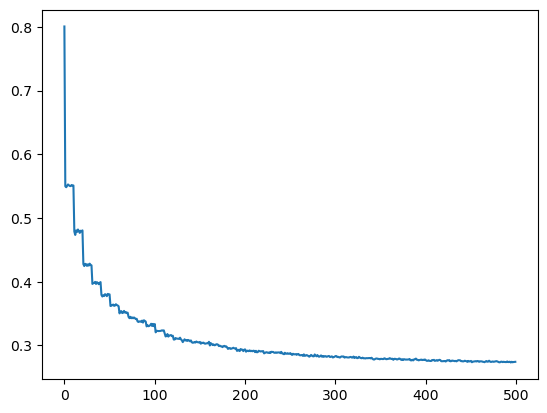

In [73]:
plt.plot(range(epochs),losses)

In [74]:
with torch.no_grad():
    y_val = gpu_model(cat_test,con_test)
    loss = criterion(y_val,y_test)

In [75]:
loss

tensor(0.2674, device='cuda:0')

In [76]:
'''for i in range(20):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i}.) PREDICTED: {y_val[i].item():8.2f} TRUE: {y_test[i].item():8.2f}  DIFF: {diff:8.2f}')'''

"for i in range(20):\n    diff = np.abs(y_val[i].item()-y_test[i].item())\n    print(f'{i}.) PREDICTED: {y_val[i].item():8.2f} TRUE: {y_test[i].item():8.2f}  DIFF: {diff:8.2f}')"

In [77]:
rows = 50
correct = 0
print (f' {"MODEL OUTPUT":40} ARGMAX Y_TEST')
for i in range (rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print (f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

 MODEL OUTPUT                             ARGMAX Y_TEST
tensor([ 1.6043, -2.9192], device='cuda:0')    0      0   
tensor([-4.0048,  1.6404], device='cuda:0')    1      0   
tensor([ 1.5894, -1.0942], device='cuda:0')    0      0   
tensor([-2.8772,  0.7596], device='cuda:0')    1      1   
tensor([ 1.3592, -1.9284], device='cuda:0')    0      0   
tensor([ 1.4387, -1.6770], device='cuda:0')    0      0   
tensor([ 2.5218, -1.3122], device='cuda:0')    0      0   
tensor([-2.9240,  1.7144], device='cuda:0')    1      1   
tensor([ 1.7932, -2.0067], device='cuda:0')    0      0   
tensor([0.0117, 0.8557], device='cuda:0')    1      1   
tensor([ 1.2991, -1.4787], device='cuda:0')    0      0   
tensor([ 1.4336, -1.5380], device='cuda:0')    0      0   
tensor([ 1.0921, -0.7071], device='cuda:0')    0      0   
tensor([-2.0801,  1.5604], device='cuda:0')    1      1   
tensor([ 1.8605, -1.5007], device='cuda:0')    0      0   
tensor([-6.0339,  2.2834], device='cuda:0')    1      1   
te